<a href="https://colab.research.google.com/github/nickdlc/CSc460-Project/blob/main/Full_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from scipy import interp

from sklearn import tree
from sklearn import svm, datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib inline

# Exploratory Data Analysis

## Does Demographic, Occupation, and Income influence people's perceptions on their health?

Dataset Source: NHANES 2017-2018
https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017

## Our y is BMI and General health condition from the Body Measures and Current Health Status Datasets respectively

In [146]:
# Demographic Data
# https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm
link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT'
demo_cols = ['ID',
             'Data release cycle',
             'Interview/Examination status',
             'Gender',
             'Age in years at screening',
             'Age in months at screening - 0 to 24 mos',
             'Race/Hispanic origin',
             'Race/Hispanic origin w/ NH Asian',
             'Six month time period',
             'Age in months at exam - 0 to 19 years',
             'Served active duty in US Armed Forces',
             'Served in a foreign country',
             'Country of birth',
             'Citizenship status',
             'Length of time in US',
             'Education level - Children/Youth 6-19',
             'Education level - Adults 20+',
             'Marital status',
             'Pregnancy status at exam',
             'Language of SP Interview',
             'Proxy used in SP Interview?',
             'Interpreter used in SP Interview?',
             'Language of Family Interview',
             'Proxy used in Family Interview?',
             'Interpreter used in Family Interview?',
             'Language of MEC Interview',
             'Proxy used in MEC Interview?',
             'Interpreter used in MEC Interview?',
             'Language of ACASI Interview',
             'Total number of people in the Household',
             'Total number of people in the Family',
             '# of children 5 years or younger in HH',
             '# of children 6-17 years old in HH',
             '# of adults 60 years or older in HH',
             'HH ref person\'s gender',
             'HH ref person\'s age in years',
             'HH ref person\'s education level',
             'HH ref person\'s marital status',
             'HH ref person\'s spouse\'s education level',
             'Full sample 2 year interview weight',
             'Full sample 2 year MEC exam weight',
             'Masked variance pseudo-PSU',
             'Masked variance pseudo-stratum',
             'Annual household income',
             'Annual family income',
             'Ratio of family income to poverty']
demo_df = pd.read_sas(link)
demo_df.columns = demo_cols

# Occupation and Income
# Occupation: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/OCQ_J.htm
# Income: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/INQ_J.htm
occ_link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/OCQ_J.XPT'
inc_link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/INQ_J.XPT'
occ_cols = ['ID',
            'Type of Work', 
            'Hours Worked Last Week', 
            'Usually Work 35 or More Hours?', 
            'Type of Employee', 
            'Months Worked', 
            'Overall Work Schedule', 
            'Main Reason for Not Working', 
            'Kind of Occupation Done the Longest', 
            'Duration of Longest Job']
inc_cols = ['ID',
            'Income from wages/salaries?',
            'Income from self employment?',
            'Income from Social Security or RR?',
            'Income from other disability pension?',
            'Income from retirement/survivor pension?',
            'Income from Supplemental Security Income?',
            'Income from state/county cash assistance?',
            'Income from interest/dividends or rental?',
            'Income from other sources?',
            'Monthly family income',
            'Family monthly poverty level index',
            'Family monthly poverty level category',
            'Family has savings more than $20,000?',
            'Total savings/cash assets for the family',
            'How do you get to the grocery store?']
occ_df = pd.read_sas(occ_link)
inc_df = pd.read_sas(inc_link)
occ_df.columns = occ_cols
inc_df.columns = inc_cols
inc_occ_df = pd.merge(inc_df, occ_df, on="ID")

X_df = pd.merge(demo_df, inc_occ_df, on="ID")
X_df.head(5)

,ID,Data release cycle,Interview/Examination status,Gender,Age in years at screening,Age in months at screening - 0 to 24 mos,Race/Hispanic origin,Race/Hispanic origin w/ NH Asian,Six month time period,Age in months at exam - 0 to 19 years,Served active duty in US Armed Forces,Served in a foreign country,Country of birth,Citizenship status,Length of time in US,Education level - Children/Youth 6-19,Education level - Adults 20+,Marital status,Pregnancy status at exam,Language of SP Interview,Proxy used in SP Interview?,Interpreter used in SP Interview?,Language of Family Interview,Proxy used in Family Interview?,Interpreter used in Family Interview?,Language of MEC Interview,Proxy used in MEC Interview?,Interpreter used in MEC Interview?,Language of ACASI Interview,Total number of people in the Household,Total number of people in the Family,# of children 5 years or younger in HH,# of children 6-17 years old in HH,# of adults 60 years or older in HH,HH ref person's gender,HH ref person's age in years,HH ref person's education level,HH ref person's marital status,HH ref person's spouse's education level,Full sample 2 year interview weight,Full sample 2 year MEC exam weight,Masked variance pseudo-PSU,Masked variance pseudo-stratum,Annual household income,Annual family income,Ratio of family income to poverty,Income from wages/salaries?,Income from self employment?,Income from Social Security or RR?,Income from other disability pension?,Income from retirement/survivor pension?,Income from Supplemental Security Income?,Income from state/county cash assistance?,Income from interest/dividends or rental?,Income from other sources?,Monthly family income,Family monthly poverty level index,Family monthly poverty level category,"Family has savings more than $20,000?",Total savings/cash assets for the family,How do you get to the grocery store?,Type of Work,Hours Worked Last Week,Usually Work 35 or More Hours?,Type of Employee,Months Worked,Overall Work Schedule,Main Reason for Not Working,Kind of Occupation Done the Longest,Duration of Longest Job
0,93705.0,10.0,2.0,2.0,66.0,NaN,4.0,4.0,2.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,2.0,3.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,2.0,4.0,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.49,1.0,2.0,3.0,1.0,1.0,30.0,1.0,1.0,36.0,5.0,NaN,2.0,NaN
1,93706.0,10.0,2.0,1.0,18.0,NaN,5.0,6.0,2.0,222.0,2.0,NaN,1.0,1.0,NaN,15.0,NaN,NaN,NaN,1.0,2.0,2.0,NaN,NaN,NaN,1.0,2.0,2.0,1.0,5.0,5.0,5.397605e-79,5.397605e-79,1.000000e+00,1.0,4.0,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN
2,93708.0,10.0,2.0,2.0,66.0,NaN,5.0,6.0,2.0,NaN,2.0,NaN,2.0,1.0,7.0,NaN,1.0,1.0,NaN,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,5.397605e-79,5.397605e-79,2.000000e+00,1.0,4.0,1.0,1.0,1.0,13329.450589,14372.488765,2.0,138.0,6.0,6.0,1.63,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,5.0,1.46,2.0,1.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,180.0
3,93709.0,10.0,2.0,2.0,75.0,NaN,4.0,4.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,4.0,2.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,2.0,4.0,2.0,2.0,NaN,12043.388271,12277.556662,1.0,136.0,2.0,2.0,0.41,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,0.96,1.0,2.0,1.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,6.0,1.0,360.0
4,93711.0,10.0,2.0,1.0,56.0,NaN,5.0,6.0,2.0,NaN,2.0,NaN,2.0,1.0,6.0,NaN,5.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,5.397605e-79,5.397605e-79,5.397605e-79,1.0,3.0,3.0,1.0,3.0,11178.260106,12390.919724,2.0,134.0,15.0,15.0,5.00,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,12.0,5.00,3.0,1.0,NaN,1.0,1.0,35.0,NaN,4.0,24.0,1.0,NaN,2.0,NaN


In [147]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6161 entries, 0 to 6160
Data columns (total 70 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         6161 non-null   float64
 1   Data release cycle                         6161 non-null   float64
 2   Interview/Examination status               6161 non-null   float64
 3   Gender                                     6161 non-null   float64
 4   Age in years at screening                  6161 non-null   float64
 5   Age in months at screening - 0 to 24 mos   0 non-null      float64
 6   Race/Hispanic origin                       6161 non-null   float64
 7   Race/Hispanic origin w/ NH Asian           6161 non-null   float64
 8   Six month time period                      5828 non-null   float64
 9   Age in months at exam - 0 to 19 years      557 non-null    float64
 10  Served active duty in US

In [148]:
# Current Health Status
# https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/HSQ_J.htm
link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/HSQ_J.XPT'
healthstat_cols = ['ID',
                   'General health condition',
                   'SP have head cold or chest cold',
                   'SP have stomach or intestinal illness?',
                   'SP have flu, pneumonia, ear infection?',
                   'SP donated blood in past 12 months?',
                   'How long ago was last blood donation?',
                   'Blood ever tested for HIV virus?',
                   'Source of Health Status Data']
heathstat_df = pd.read_sas(link)
heathstat_df.columns = healthstat_cols

# Body Measures
# https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.htm
link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.XPT'
body_cols = ['ID',
             'Body Measures Component Status Code',
             'Weight (kg)',
             'Weight Comment',
             'Recumbent Length (cm)',
             'Recumbent Length Comment',
             'Head Circumference (cm)',
             'Head Circumference Comment',
             'Standing Height (cm)',
             'Standing Height Comment',
             'Body Mass Index (kg/m**2)',
             'Upper Leg Length (cm)',
             'Upper Leg Length Comment',
             'Upper Arm Length (cm)',
             'Upper Arm Length Comment',
             'Arm Circumference (cm)',
             'Arm Circumference Comment',
             'Waist Circumference (cm)',
             'Waist Circumference Comment',
             'Hip Circumference (cm)',
             'Hip Circumference Comment']
body_df = pd.read_sas(link)
body_df.columns = body_cols

y_df = pd.merge(heathstat_df, body_df, on="ID")
y_df.head(5)

,ID,General health condition,SP have head cold or chest cold,SP have stomach or intestinal illness?,"SP have flu, pneumonia, ear infection?",SP donated blood in past 12 months?,How long ago was last blood donation?,Blood ever tested for HIV virus?,Source of Health Status Data,Body Measures Component Status Code,Weight (kg),Weight Comment,Recumbent Length (cm),Recumbent Length Comment,Head Circumference (cm),Head Circumference Comment,Standing Height (cm),Standing Height Comment,Body Mass Index (kg/m**2),Upper Leg Length (cm),Upper Leg Length Comment,Upper Arm Length (cm),Upper Arm Length Comment,Arm Circumference (cm),Arm Circumference Comment,Waist Circumference (cm),Waist Circumference Comment,Hip Circumference (cm),Hip Circumference Comment
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,13.7,3.0,89.6,NaN,NaN,NaN,88.6,NaN,17.5,NaN,NaN,18.0,NaN,16.2,NaN,48.2,NaN,NaN,NaN
1,93704.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,1.0,1.0,13.9,NaN,95.0,NaN,NaN,NaN,94.2,NaN,15.7,NaN,NaN,18.6,NaN,15.2,NaN,50.0,NaN,NaN,NaN
2,93705.0,3.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,1.0,79.5,NaN,NaN,NaN,NaN,NaN,158.3,NaN,31.7,37.0,NaN,36.0,NaN,32.0,NaN,101.8,NaN,110.0,NaN
3,93706.0,2.0,2.0,2.0,2.0,1.0,5.0,2.0,2.0,1.0,66.3,NaN,NaN,NaN,NaN,NaN,175.7,NaN,21.5,46.6,NaN,38.8,NaN,27.0,NaN,79.3,NaN,94.4,NaN
4,93707.0,3.0,2.0,2.0,2.0,NaN,NaN,NaN,2.0,1.0,45.4,NaN,NaN,NaN,NaN,NaN,158.4,NaN,18.1,38.1,NaN,33.8,NaN,21.5,NaN,64.1,NaN,83.0,NaN


In [149]:
# Remove cols
labels_df = y_df[['ID','General health condition', 'Body Mass Index (kg/m**2)']]
labels_df = labels_df[labels_df['General health condition'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]
labels_df.head(5)

,ID,General health condition,Body Mass Index (kg/m**2)
2,93705.0,3.0,31.7
3,93706.0,2.0,21.5
4,93707.0,3.0,18.1
5,93708.0,3.0,23.7
7,93711.0,2.0,21.3


## What is the relation between people's BMIs and their perceived general health condition? 
In the Current Health Status survey, people recorded their perceived general health condition on a scale of 1-5. I removed the "Refused", "Don't know", and "Not recorded" values.

1 	Excellent 	619 	619 	
2 	Very good 	1544 	2163 	
3 	Good 	    2454 	4617 	
4 	Fair    	1175 	5792 	
5 	Poor        172 	5964

I plotted people's BMIs against their perceived health to see if there was a relationship. I expected a bell curve-people who were in a healthy weight should perceive themselves as healthy individuals. However, that was not the case. Weight is not the only predictor of health and even if it were, people have altered perceptions of health. 


Note the vertical lines delimiting the BMI Health Status Categories:
Below 18.5	Underweight
18.5—24.9	Healthy
25.0—29.9	Overweight
30.0 and Above	Obese

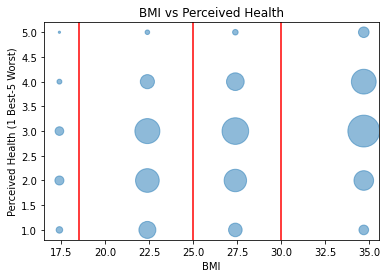

In [150]:
import statistics
new_ydf = y_df[['Body Mass Index (kg/m**2)','General health condition']]
# Clean dataset by using only rows where GHC=[1,5] and BMI not null
new_ydf = new_ydf[new_ydf['General health condition'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]
new_ydf = new_ydf.dropna(subset=['Body Mass Index (kg/m**2)'])

# Replace BMI in each subgroup with their median
new_ydf['Body Mass Index (kg/m**2)'][new_ydf['Body Mass Index (kg/m**2)'] <= 18.5] = statistics.median(new_ydf['Body Mass Index (kg/m**2)'][new_ydf['Body Mass Index (kg/m**2)'] <= 18.5])
new_ydf['Body Mass Index (kg/m**2)'][(new_ydf['Body Mass Index (kg/m**2)']>18.5) & (new_ydf['Body Mass Index (kg/m**2)']<=25)] = statistics.median(new_ydf['Body Mass Index (kg/m**2)'][(new_ydf['Body Mass Index (kg/m**2)']>18.5) & (new_ydf['Body Mass Index (kg/m**2)']<=25)])
new_ydf['Body Mass Index (kg/m**2)'][(new_ydf['Body Mass Index (kg/m**2)']>25) & (new_ydf['Body Mass Index (kg/m**2)']<=30)] = statistics.median(new_ydf['Body Mass Index (kg/m**2)'][(new_ydf['Body Mass Index (kg/m**2)']>25) & (new_ydf['Body Mass Index (kg/m**2)']<=30)])
new_ydf['Body Mass Index (kg/m**2)'][new_ydf['Body Mass Index (kg/m**2)']>30] = statistics.median(new_ydf['Body Mass Index (kg/m**2)'][new_ydf['Body Mass Index (kg/m**2)']>30])
# Get the count of people in each BMI subgroup and adds it as a column. Then, remove duplicates
new_ydf=new_ydf.value_counts().to_frame().reset_index()
new_ydf=new_ydf.drop_duplicates()


new_bmi = new_ydf['Body Mass Index (kg/m**2)']
new_ghc = new_ydf['General health condition']
plt.scatter(new_bmi, new_ghc, alpha=0.5, s=new_ydf[0])
plt.axvline(x=18.5, color = 'red')
plt.axvline(x=25, color = 'red')
plt.axvline(x=30, color = 'red')
plt.xlabel("BMI")
plt.ylabel("Perceived Health (1 Best-5 Worst)")
plt.title("BMI vs Perceived Health")
# plt.savefig('fig/bmi_ghc.png', dpi=600)
plt.show()


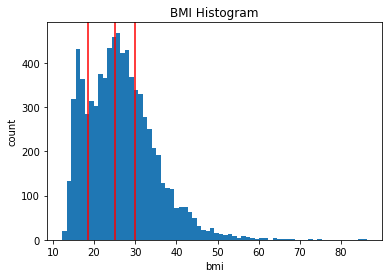

In [151]:
a = np.hstack(y_df['Body Mass Index (kg/m**2)'])
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.axvline(x=18.5, color = 'red')
plt.axvline(x=25, color = 'red')
plt.axvline(x=30, color = 'red')
plt.title("BMI Histogram")
plt.xlabel("bmi")
plt.ylabel("count")
# plt.savefig('fig/bmi_histogram.png', dpi=600)
plt.show()

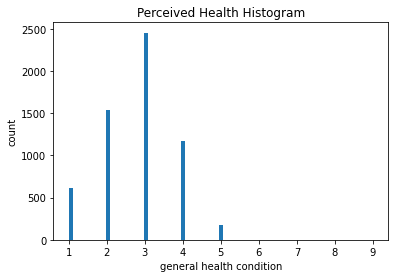

In [152]:
a = np.hstack(y_df['General health condition'])
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Perceived Health Histogram")
plt.xlabel("general health condition")
plt.ylabel("count")
# plt.savefig('fig/ghc_histogram.png', dpi=600)
plt.show()

## So we see a discrepancy in how people perceive their health and their "actual" health, assuming BMI reflects people's actual health. 

## Based on X, can we classify people's perceived health and then predict their BMI?

In [153]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6161 entries, 0 to 6160
Data columns (total 70 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         6161 non-null   float64
 1   Data release cycle                         6161 non-null   float64
 2   Interview/Examination status               6161 non-null   float64
 3   Gender                                     6161 non-null   float64
 4   Age in years at screening                  6161 non-null   float64
 5   Age in months at screening - 0 to 24 mos   0 non-null      float64
 6   Race/Hispanic origin                       6161 non-null   float64
 7   Race/Hispanic origin w/ NH Asian           6161 non-null   float64
 8   Six month time period                      5828 non-null   float64
 9   Age in months at exam - 0 to 19 years      557 non-null    float64
 10  Served active duty in US

In [154]:
features = ['ID',
            'HH ref person\'s gender',
            'HH ref person\'s age in years',
            'HH ref person\'s education level',
            'Race/Hispanic origin w/ NH Asian',
            'Total savings/cash assets for the family',
            'Annual family income']
features_df = X_df[features]
df = pd.merge(features_df, labels_df, on="ID")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5417 entries, 0 to 5416
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ID                                        5417 non-null   float64
 1   HH ref person's gender                    5417 non-null   float64
 2   HH ref person's age in years              5417 non-null   float64
 3   HH ref person's education level           5181 non-null   float64
 4   Race/Hispanic origin w/ NH Asian          5417 non-null   float64
 5   Total savings/cash assets for the family  3455 non-null   float64
 6   Annual family income                      5171 non-null   float64
 7   General health condition                  5417 non-null   float64
 8   Body Mass Index (kg/m**2)                 5348 non-null   float64
dtypes: float64(9)
memory usage: 423.2 KB


# Data Cleaning

In [155]:
# Clean Data to get rid of error:
# Input contains NaN, infinity or a value too large for dtype('float32').

df.isna().sum()

ID                                             0
HH ref person's gender                         0
HH ref person's age in years                   0
HH ref person's education level              236
Race/Hispanic origin w/ NH Asian               0
Total savings/cash assets for the family    1962
Annual family income                         246
General health condition                       0
Body Mass Index (kg/m**2)                     69
dtype: int64

## So we can see that 4 columns will need cleaning.

The BMI column has 69 NaN entries, but since this is one of the labels which we are predicting, it would be better to drop these values, otherwise we may be training on egregious data.

Furthermore, the household reference person's education level is missing in 236 rows. For this we will do mode imputation because this appears to be the most reliable statistic to fill the unknown values.

For the total savings/assets column, it would make sense to use mode imputation since this appears to be the most reliable way of generalizing the sample population.

For the annual family income, it would make sense to use median imputation. However, we must consider two values correspond to "Under \$20,000" and "Over \$20,000". First, we will consider any rows with the latter value as NA since "Over \$20,000" encompasses a wide range. On the other hand, "Under \$20,000" can be used to consolidate the four different ranges below \$20,000. Lastly, we will still need to consider the NA, "Refused", and "Don't know" values.

**Note:** These columns also have valid values which correspond to "Refused" or "Don't know" so we will need to perform the same imputations on these entries as well. This also implies that we should check the values without NA values to make sure there are no "Refused" or "Don't know" values.


In [156]:
# Showing that values w/ 77 & 99 exist
# 77 are people who refused to answer
# 99 are people who dont know
df[(df['Annual family income'] == 77.0) | (df['Annual family income'] == 99.0)].head(5)

,ID,HH ref person's gender,HH ref person's age in years,HH ref person's education level,Race/Hispanic origin w/ NH Asian,Total savings/cash assets for the family,Annual family income,General health condition,Body Mass Index (kg/m**2)
100,93863.0,1.0,3.0,2.0,6.0,NaN,77.0,2.0,31.6
101,93866.0,1.0,2.0,2.0,3.0,1.0,99.0,4.0,22.0
102,93868.0,1.0,4.0,1.0,4.0,NaN,77.0,4.0,35.4
111,93884.0,2.0,3.0,3.0,3.0,NaN,99.0,1.0,21.3
115,93891.0,1.0,3.0,1.0,1.0,99.0,99.0,3.0,44.6


## `HH ref person's gender` Cleaning

In [157]:
print("\nHH ref person's gender:\n".upper(), df["HH ref person's gender"].value_counts(), sep='')


HH REF PERSON'S GENDER:
1.0    2879
2.0    2538
Name: HH ref person's gender, dtype: int64


These values correspond to male and female respectively so we don't need to do any more cleaning.

## `HH ref person's age in years` Cleaning

In [158]:
print("\nHH ref person's age in years:\n".upper(), df["HH ref person's age in years"].value_counts(), sep='')


HH REF PERSON'S AGE IN YEARS:
3.0    2073
4.0    1939
2.0    1325
1.0      80
Name: HH ref person's age in years, dtype: int64


None of these correspond to "Refused" or "Don't know" nor have overlapping ranges, so no extra cleaning is needed.

## `HH ref person's education level` Cleaning

In [159]:
print("\nHH ref person's education level:\n".upper(), df["HH ref person's education level"].value_counts(), sep='')


HH REF PERSON'S EDUCATION LEVEL:
2.0    2964
3.0    1252
1.0     965
Name: HH ref person's education level, dtype: int64


From the above code, we can see that there are no extra values denoting "Refused" or "Don't know" so we can just work with replacing NA values.

In [160]:
# setting value to mode
edu_lvl_dict = {
    "HH ref person's education level": df["HH ref person's education level"].value_counts().index[0]
}

df = df.fillna(value=edu_lvl_dict)
df.isna().sum()

ID                                             0
HH ref person's gender                         0
HH ref person's age in years                   0
HH ref person's education level                0
Race/Hispanic origin w/ NH Asian               0
Total savings/cash assets for the family    1962
Annual family income                         246
General health condition                       0
Body Mass Index (kg/m**2)                     69
dtype: int64

## `Race/Hispanic origin w/ NH Asian` Cleaning

In [161]:
print("\nRace/Hispanic origin w/ NH Asian:\n".upper(), df["Race/Hispanic origin w/ NH Asian"].value_counts(), sep='')


RACE/HISPANIC ORIGIN W/ NH ASIAN:
3.0    1907
4.0    1253
1.0     753
6.0     724
2.0     479
7.0     301
Name: Race/Hispanic origin w/ NH Asian, dtype: int64


None of these values correspond to "Refused" or "Don't know", so no extra cleaning is needed.

## `Total savings/cash assets for the family` Cleaning

In [162]:
print('Total savings/cash assets for the family:\n'.upper(), df['Total savings/cash assets for the family'].value_counts(), sep='')

TOTAL SAVINGS/CASH ASSETS FOR THE FAMILY:
1.0     2617
2.0      308
3.0      281
4.0      113
99.0      64
5.0       48
77.0      24
Name: Total savings/cash assets for the family, dtype: int64


In [163]:
# Replace 77.0 & 99.0 w/ NaN

df['Total savings/cash assets for the family'] = df['Total savings/cash assets for the family'].replace([77.0, 99.0], [np.nan, np.nan])
df.isna().sum()

ID                                             0
HH ref person's gender                         0
HH ref person's age in years                   0
HH ref person's education level                0
Race/Hispanic origin w/ NH Asian               0
Total savings/cash assets for the family    2050
Annual family income                         246
General health condition                       0
Body Mass Index (kg/m**2)                     69
dtype: int64

In [164]:
# Replace all NaNs with the mode

savings_assets_dict = {
    "Total savings/cash assets for the family": df["Total savings/cash assets for the family"].value_counts().index[0]
}

df = df.fillna(value=savings_assets_dict)
df.isna().sum()

ID                                            0
HH ref person's gender                        0
HH ref person's age in years                  0
HH ref person's education level               0
Race/Hispanic origin w/ NH Asian              0
Total savings/cash assets for the family      0
Annual family income                        246
General health condition                      0
Body Mass Index (kg/m**2)                    69
dtype: int64

## `Annual family income` Cleaning

In [165]:
print('ANNUAL FAMILY INCOME VALUES:\n', df['Annual family income'].value_counts(), sep='')

ANNUAL FAMILY INCOME VALUES:
15.0    930
6.0     583
7.0     542
14.0    476
8.0     362
5.0     349
4.0     327
9.0     301
3.0     278
10.0    238
1.0     190
2.0     172
12.0    135
99.0    115
77.0    101
13.0     72
Name: Annual family income, dtype: int64


12.0 -> \$20,000 and Over

13.0 -> \$20,000 and Under



In [166]:
# Remove instances with income == value 12.0

df = df[df['Annual family income'] != 12.0]
print('ANNUAL FAMILY INCOME VALUES:\n', df['Annual family income'].value_counts(), sep='')

ANNUAL FAMILY INCOME VALUES:
15.0    930
6.0     583
7.0     542
14.0    476
8.0     362
5.0     349
4.0     327
9.0     301
3.0     278
10.0    238
1.0     190
2.0     172
99.0    115
77.0    101
13.0     72
Name: Annual family income, dtype: int64


In [167]:
# Replace "Refused" and "Don't know" values with NaN
df['Annual family income'] = df['Annual family income'].replace([77.0, 99.0], np.nan)
df.isna().sum()

ID                                            0
HH ref person's gender                        0
HH ref person's age in years                  0
HH ref person's education level               0
Race/Hispanic origin w/ NH Asian              0
Total savings/cash assets for the family      0
Annual family income                        462
General health condition                      0
Body Mass Index (kg/m**2)                    69
dtype: int64

In [168]:
# Replace any ranges below $20k with the general "Under $20k" label
df['Annual family income'] = df['Annual family income'].replace([1.0, 2.0, 3.0, 4.0], 13.0)
print('ANNUAL FAMILY INCOME VALUES:\n', df['Annual family income'].value_counts(), sep='')

ANNUAL FAMILY INCOME VALUES:
13.0    1039
15.0     930
6.0      583
7.0      542
14.0     476
8.0      362
5.0      349
9.0      301
10.0     238
Name: Annual family income, dtype: int64


In [169]:
# Re-index the feature values
ann_fam_income_map = dict(enumerate([13.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 14.0, 15.0]))
ann_fam_income_map

{0: 13.0, 1: 5.0, 2: 6.0, 3: 7.0, 4: 8.0, 5: 9.0, 6: 10.0, 7: 14.0, 8: 15.0}

In [170]:
# Replace the current feature values with the enumerated ones
df['Annual family income'] = df['Annual family income'].replace(ann_fam_income_map.values(), ann_fam_income_map.keys())
print('ANNUAL FAMILY INCOME VALUES:\n', df['Annual family income'].value_counts(), sep='')

ANNUAL FAMILY INCOME VALUES:
0.0    1039
8.0     930
2.0     583
3.0     542
7.0     476
4.0     362
1.0     349
5.0     301
6.0     238
Name: Annual family income, dtype: int64


In [171]:
# Replace NA

ann_fam_income_dict = {
    "Annual family income": df["Annual family income"].median()
}

df = df.fillna(value=ann_fam_income_dict)
df.isna().sum()

ID                                           0
HH ref person's gender                       0
HH ref person's age in years                 0
HH ref person's education level              0
Race/Hispanic origin w/ NH Asian             0
Total savings/cash assets for the family     0
Annual family income                         0
General health condition                     0
Body Mass Index (kg/m**2)                   69
dtype: int64

## `General health condition` Cleaning

In [172]:
print("\nGeneral health condition:\n".upper(), df["General health condition"].value_counts(), sep='')


GENERAL HEALTH CONDITION:
3.0    2201
2.0    1316
4.0    1115
1.0     485
5.0     165
Name: General health condition, dtype: int64


None of these values correspond to "Refused" or "Don't know", so no extra cleaning is needed.

## `Body Mass Index (kg/m**2)` Cleaning

In [173]:
# Remove any NA values

df = df[df['Body Mass Index (kg/m**2)'].notna()]
df.isna().sum()

ID                                          0
HH ref person's gender                      0
HH ref person's age in years                0
HH ref person's education level             0
Race/Hispanic origin w/ NH Asian            0
Total savings/cash assets for the family    0
Annual family income                        0
General health condition                    0
Body Mass Index (kg/m**2)                   0
dtype: int64

In [174]:
df.head(5)

,ID,HH ref person's gender,HH ref person's age in years,HH ref person's education level,Race/Hispanic origin w/ NH Asian,Total savings/cash assets for the family,Annual family income,General health condition,Body Mass Index (kg/m**2)
0,93705.0,2.0,4.0,1.0,4.0,3.0,0.0,3.0,31.7
1,93706.0,1.0,4.0,3.0,6.0,1.0,3.0,2.0,21.5
2,93708.0,1.0,4.0,1.0,6.0,1.0,2.0,3.0,23.7
3,93711.0,1.0,3.0,3.0,6.0,1.0,8.0,2.0,21.3
4,93712.0,2.0,3.0,1.0,1.0,1.0,0.0,3.0,19.7


# Classification of `General Health Condition` based on feature variables

In [190]:
# Convert the DataFrame to a NumPy array
df_arr = df.to_numpy()
# Segregate features and labels into separate variables
X,y = df_arr[:,1:6], df_arr[:,7]

scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Test Accuracy of Decision Tree: ", accuracy_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred, average='micro'))
print("Recall Score: ", recall_score(y_test, y_pred, average='micro'))
print("F1 Score: ", f1_score(y_test, y_pred, average='micro'))

Test Accuracy of Decision Tree:  0.41545613015688554
Precision Score:  0.41545613015688554
Recall Score:  0.41545613015688554
F1 Score:  0.41545613015688554


It turns out that removing `Annual family income` from our features list raises the accuracy from ~36.6% to ~41.5%.

## Cross-Validation

### Grid Search Cross-Validation

In [176]:
# Define the grid of values for tol and max_iter
max_depth = [1,2,3,4,5]

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict(max_depth=max_depth, max_features=['auto', 'sqrt', 'log2', 0.5], min_samples_split=[3,4,5,6])

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)

# Use scaler to rescale X and assign it to rescaledX
rescaledX = scaler.fit_transform(X)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX, y)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.420104 using {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 3}


So by running a grid search cross-validation, we are able to improve our accuracy to ~42% from ~41.5%.

### K-Fold Cross-Validation

In [177]:
# Set up our K-fold cross-validation
kf = KFold(3000)

# Train our models using KFold cv
tree_score = cross_val_score(clf, X, y, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score))

Decision Tree: 0.4106666666666667


So we see that a K-fold cross-validation actually decreases the performance of our model.

## Confusion Matrices

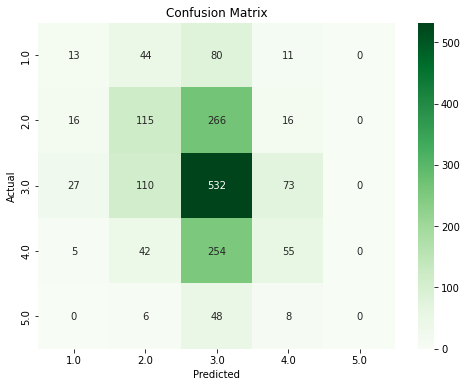

In [179]:
# Print Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(matrix, annot=True,cmap='Greens', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.xaxis.set_ticklabels([1.0, 2.0, 3.0, 4.0, 5.0]); 
ax.yaxis.set_ticklabels([1.0, 2.0, 3.0, 4.0, 5.0]);
# plt.savefig('fig/confusion_matrix.png', dpi=600)


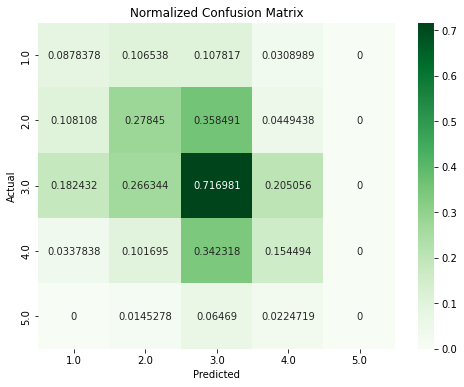

In [180]:
normalized = matrix/matrix.astype(np.float).sum(axis=1)
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(normalized, annot=True,cmap='Greens', fmt='g')
plt.title("Normalized Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.xaxis.set_ticklabels([1.0, 2.0, 3.0, 4.0, 5.0]); 
ax.yaxis.set_ticklabels([1.0, 2.0, 3.0, 4.0, 5.0]);
# plt.savefig('fig/normalized_confusion_matrix.png', dpi=600)

## PCA 

Text(0, 0.5, 'Explained Variance Ratio')

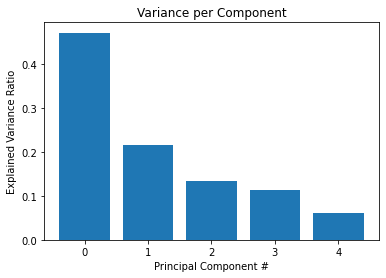

In [181]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(X)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')
plt.title("Variance per Component")
plt.ylabel('Explained Variance Ratio')
# plt.savefig('fig/pca_variance.png', dpi=600)


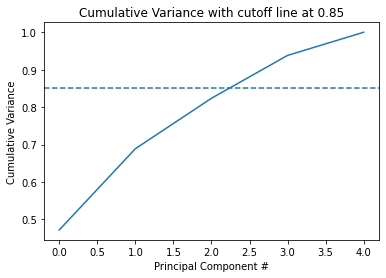

In [182]:
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
ax.set_xlabel('Principal Component #')
plt.title("Cumulative Variance with cutoff line at 0.85")
plt.ylabel('Cumulative Variance')
# plt.savefig('fig/pca_cumvariance.png', dpi=600)

# choose the n_components where about 85% of our variance can be explained
n_components = 4

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(X)
pca_projection = pca.transform(X)


In [183]:
X_train, X_test, y_train, y_test = train_test_split(pca_projection,
                                                    y,
                                                    test_size=0.4,
                                                    random_state=42)

clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Train Accuracy of Decision Tree: ", clf.score(X_train, y_train))
print("Test Accuracy of Decision Tree: ", accuracy_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred, average='micro'))
print("Recall Score: ", recall_score(y_test, y_pred, average='micro'))
print("F1 Score: ", f1_score(y_test, y_pred, average='micro'))

Train Accuracy of Decision Tree:  0.4860889031020147
Test Accuracy of Decision Tree:  0.40364333652924256
Precision Score:  0.40364333652924256
Recall Score:  0.40364333652924256
F1 Score:  0.40364333652924256


## ROC Curve

In [184]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=42)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


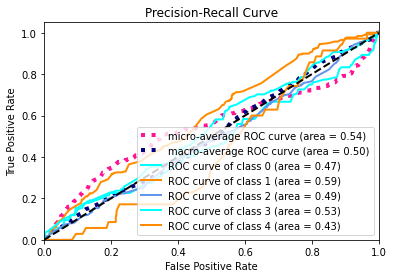

In [185]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower right")
# plt.savefig('fig/roc_curve.png', dpi=600)
plt.show()


In [186]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.535827 (macro),
0.515227 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.535827 (macro),
0.515227 (weighted by prevalence)


# Attempt at Linear Regression for Body Mass Index

In [187]:
X_ghc, y_bmi = df_arr[:,7].reshape(-1,1), df_arr[:,8]

X_ghc_train, X_ghc_test, y_bmi_train, y_bmi_test = train_test_split(X_ghc, y_bmi, test_size=0.33, random_state=42)

reg = LinearRegression()
reg.fit(X_ghc_train, y_bmi_train)
y_bmi_pred = reg.predict(X_ghc_test)
print("Accuracy of Linear Regression: ", reg.score(X_ghc_test, y_bmi_test))

Accuracy of Linear Regression:  0.0630335374414831


As we can see here, the linear regression on body mass index has an accuracy of 6%.

# Attempts to Improve Decision Tree Model Accuracy

## Subsets of Features

In [188]:
# all HH ref people under 50
category_filters = {
    "Gender: Male": df[df["HH ref person's gender"] == 1],
    "Gender: Female": df[df["HH ref person's gender"] == 2],
    "Age 20-59": df[df["HH ref person's age in years"].isin((2, 3))],
    "Age <20 and 60+": df[df["HH ref person's age in years"].isin((1, 4))],
    "Less than high school": df[df["HH ref person's education level"] == 1],
    "At least high school/GED": df[df["HH ref person's education level"].isin((2, 3))],
    "Hispanic": df[df["Race/Hispanic origin w/ NH Asian"].isin((1, 2))],
    "Non-Hispanic White": df[df["Race/Hispanic origin w/ NH Asian"] == 3],
    "Non-Hispanic Black": df[df["Race/Hispanic origin w/ NH Asian"] == 4],
    "Non-Hispanic Asian": df[df["Race/Hispanic origin w/ NH Asian"] == 6],
    "Other Race - Including Multi-Racial": df[df["Race/Hispanic origin w/ NH Asian"] == 7],
    "Savings <$3000": df[df["Total savings/cash assets for the family"] == 1],
    "Savings >=$3000": df[df["Total savings/cash assets for the family"] != 1],
    "Income <$35,000": df[df["Annual family income"].isin((0, 1, 2))],
    "Income $35,000-$64,999": df[df["Annual family income"].isin((3, 4, 5))],
    "Income >=$65,000": df[df["Annual family income"].isin((6, 7, 8))]
}

def run_model_on_df(category, df_categorized):
  # Convert the DataFrame to a NumPy array
  df_categorized_np = df_categorized.to_numpy()
  # Segregate features and labels into separate variables
  X,y = df_categorized_np[:,1:6] , df_categorized_np[:,7]

  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.33,
                                                      random_state=42)
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)

  clf = tree.DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(f"Accuracy of {category}:", clf.score(X_test, y_test))
  print(f1_score(y_test, y_pred, average='micro'))

for category, df_categorized in category_filters.items():
  run_model_on_df(category, df_categorized)

Accuracy of Gender: Male: 0.3940724478594951
0.394072447859495
Accuracy of Gender: Female: 0.4185185185185185
0.4185185185185185
Accuracy of Age 20-59: 0.3948339483394834
0.3948339483394834
Accuracy of Age <20 and 60+: 0.41444270015698587
0.41444270015698587
Accuracy of Less than high school: 0.40327868852459015
0.40327868852459015
Accuracy of At least high school/GED: 0.3961864406779661
0.3961864406779661
Accuracy of Hispanic: 0.3769230769230769
0.3769230769230769
Accuracy of Non-Hispanic White: 0.4372937293729373
0.4372937293729373
Accuracy of Non-Hispanic Black: 0.39900249376558605
0.39900249376558605
Accuracy of Non-Hispanic Asian: 0.3406113537117904
0.3406113537117904
Accuracy of Other Race - Including Multi-Racial: 0.3917525773195876
0.3917525773195876
Accuracy of Savings <$3000: 0.40823211875843457
0.40823211875843457
Accuracy of Savings >=$3000: 0.375
0.375
Accuracy of Income <$35,000: 0.35569422776911075
0.35569422776911075
Accuracy of Income $35,000-$64,999: 0.352398523985239

As you can see, our model performs the best, around 43.7%, with Non-Hispanic Whites and does the worst, around 34.1%, with Non-Hispanic Asians. 